# Amazon Forecast の Get Started サンプル（電力需要予測）を回帰問題としてXGBoostでモデル化する

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/gs-console.html

36時間後までを予測するため、36時間前の情報から予測する必要があります。

## 0.環境準備

In [3]:
import sys
print(sys.path)
sys.path.append('/usr/local/lib/python3.7/site-packages')
print('-------------------------------')
print(sys.path)

['/root/data/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/.sagemakerinternal/conda/lib/python37.zip', '/opt/.sagemakerinternal/conda/lib/python3.7', '/opt/.sagemakerinternal/conda/lib/python3.7/lib-dynload', '', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']
-------------------------------
['/root/data/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/.sagemakerinternal/conda/lib/python37.zip', '/opt/.sagemakerinternal/conda/lib/python3.7', '/opt/.sagemakerinternal/conda/lib/python3.7/lib-dynload', '', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.7/site-packages']


In [33]:
pip freeze # condaの環境が出力される？

argcomplete==1.12.3
asn1crypto==0.24.0
async-generator==1.10
attrs==21.2.0
backcall==0.2.0
bleach==4.1.0
certifi==2021.10.8
cffi==1.12.2
chardet==3.0.4
colorama==0.4.4
conda==4.10.3
conda-package-handling==1.7.3
cryptography==2.6.1
debugpy==1.5.0
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
idna==2.8
importlib-metadata==4.8.1
ipykernel==6.4.1
ipython==7.28.0
ipython-genutils==0.2.0
jedi==0.18.0
Jinja2==3.0.2
jsonschema==4.1.0
jupyter-client==6.1.13
jupyter-core==4.8.1
jupyter-kernel-gateway==2.4.0
jupyter-telemetry==0.1.0
jupyterlab-pygments==0.1.2
MarkupSafe==2.0.1
matplotlib-inline==0.1.3
mistune==0.8.4
nb-conda-kernels==2.3.1
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.0.3
packaging==21.0
pandocfilters==1.5.0
parso==0.8.2
pexpect==4.8.0
pickleshare==0.7.5
prometheus-client==0.11.0
prompt-toolkit==3.0.20
psutil==5.8.0
ptyprocess==0.7.0
pycosat==0.6.3
pycparser==2.19
Pygments==2.10.0
pyOpenSSL==19.0.0
pyparsing==2.4.7
pyrsistent==0.18.0
PySo

In [34]:
!pip freeze # コンテナの環境が出力される

ansiwrap==0.8.4
argcomplete==1.12.3
argon2-cffi==21.1.0
attrs==21.2.0
backcall==0.2.0
black==21.9b0
bleach==4.1.0
boto3==1.19.2
botocore==1.22.2
certifi==2021.10.8
cffi==1.15.0
charset-normalizer==2.0.7
click==8.0.3
debugpy==1.5.1
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
idna==3.3
importlib-metadata==4.8.1
ipykernel==6.4.2
ipython==7.28.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.0
Jinja2==3.0.2
jmespath==0.10.0
joblib==1.1.0
jsonschema==4.1.2
jupyter==1.0.0
jupyter-client==7.0.6
jupyter-console==6.4.0
jupyter-core==4.8.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
lightgbm==3.3.0
MarkupSafe==2.0.1
matplotlib-inline==0.1.3
mistune==0.8.4
mypy-extensions==0.4.3
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.4.5
nteract-scrapbook==0.4.2
numpy==1.21.3
packaging==21.0
pandas==1.3.4
pandocfilters==1.5.0
papermill==2.3.3
parso==0.8.2
pathspec==0.9.0
pexpect==4.8.0
pickleshare==0.7.5
platformdirs==2.4.0
prometheus-client==0.11.0

## 1.データセット読み込み

In [4]:
import pandas as pd

In [6]:
df = pd.read_csv('../input/electricityusagedata.zip', names=['timestamp','demand','client'])

In [7]:
print(df.shape)
print(df['timestamp'].min())
print(df['timestamp'].max())
df.head()

(3241200, 3)
2014-01-01 01:00:00
2015-01-01 00:00:00


,timestamp,demand,client
0,2014-01-01 01:00:00,2.538071,client_0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [8]:
df['client'] = df['client'].str.replace('client_','').astype(int)

## 2.特徴量生成

### 1)時刻型に変換し、特徴量（時間帯、曜日）を抽出

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [10]:
df['num_of_week'] = df['timestamp'].dt.dayofweek

In [11]:
df['hour'] = df['timestamp'].dt.hour

### 2)clientごとに時間差の値を特徴量にもつ（36hより前である必要がある）

In [12]:
df["before_36h"] = df.groupby(['client']).shift(36)['demand'].reset_index()['demand']
df["before_37h"] = df.groupby(['client']).shift(37)['demand'].reset_index()['demand']
df["before_38h"] = df.groupby(['client']).shift(38)['demand'].reset_index()['demand']
df["before_48h"] = df.groupby(['client']).shift(48)['demand'].reset_index()['demand']
df["before_72h"] = df.groupby(['client']).shift(72)['demand'].reset_index()['demand']
df["before_96h"] = df.groupby(['client']).shift(96)['demand'].reset_index()['demand']

### 3)clientごとに期間で集約する

In [13]:
df = df.sort_values(["client","timestamp"]).reset_index()
df['mean_24h'] = df.groupby(['client']).rolling(24)['demand'].mean().reset_index()['demand']
df['var_24h'] = df.groupby(['client']).rolling(24)['demand'].var().reset_index()['demand']

In [14]:
#df = df.sort_values(["client","timestamp"]).reset_index()
#df['mean_24h_before_36h'] = df.groupby(['client']).rolling(2)['demand'].mean().reset_index()['demand']

In [15]:
df["mean_24h_before_36h"] = df.groupby(['client']).shift(36)['mean_24h'].reset_index()['mean_24h']
df["var_24h_before_36h"] = df.groupby(['client']).shift(36)['var_24h'].reset_index()['var_24h']

In [16]:
df[df.client==21].head()

,index,timestamp,demand,client,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
183960,21,2014-01-01 01:00:00,29.887920,21,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183961,391,2014-01-01 02:00:00,28.953923,21,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183962,761,2014-01-01 03:00:00,28.953923,21,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183963,1131,2014-01-01 04:00:00,25.373599,21,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183964,1501,2014-01-01 05:00:00,23.661270,21,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df[df.client==21].tail()

,index,timestamp,demand,client,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
192715,3239371,2014-12-31 20:00:00,43.586550,21,2,20,28.798257,25.062267,25.996264,53.237858,42.029888,45.143213,25.289280,47.597890,36.795610,94.835153
192716,3239741,2014-12-31 21:00:00,40.317559,21,2,21,45.143213,28.798257,25.062267,47.478207,42.808219,40.940224,25.451432,51.997619,37.042082,97.544219
192717,3240111,2014-12-31 22:00:00,36.581569,21,2,22,51.992528,45.143213,28.798257,36.581569,41.718555,36.737235,25.658987,55.694928,37.113429,99.637520
192718,3240481,2014-12-31 23:00:00,32.222914,21,2,23,52.148194,51.992528,45.143213,32.222914,33.156912,36.892902,25.886000,57.460307,37.450706,107.252683
192719,3240851,2015-01-01 00:00:00,33.935243,21,3,0,45.765878,52.148194,51.992528,33.623910,30.666252,33.468244,26.184361,60.150056,37.353414,105.317417


In [18]:
feature_col = [
    'client',
    'num_of_week',
    'hour',
    'before_36h',
    'before_37h',
    'before_38h',
    'before_48h',
    'before_72h',
    'before_96h',
    'mean_24h_before_36h',
    'var_24h_before_36h'
]

## 3.データ分割
all:2014-01-01 01:00:00 〜 2015-01-01 00:00:00  
train:2014-01-01 01:00:00 〜 2014-12-29 00:00:00  
valid:2014-12-29 01:00:00 〜 2014-12-30 12:00:00(36h)  
test:2014-12-30 13:00:00 〜 2015-01-01 00:00:00(36h)  

In [19]:
df_train = df[df.timestamp <= '2014-12-29 00:00:00']

In [20]:
df_valid = df[(df.timestamp >= '2014-12-29 01:00:00') & (df.timestamp <= '2014-12-30 12:00:00')]

In [21]:
df_test = df[df.timestamp >= '2014-12-30 13:00:00']

In [22]:
df_train[df_train.client==21].shape

(8688, 16)

In [23]:
df_valid[df_valid.client==21].shape

(36, 16)

In [24]:
df_test[df_test.client==21].shape

(36, 16)

In [25]:
tr_x = df_train[feature_col]
tr_y = df_train['demand']

In [26]:
va_x = df_valid[feature_col]
va_y = df_valid['demand']

In [27]:
test_x = df_test[feature_col]
test_y = df_test[['timestamp','client','demand']]

In [35]:
import xgboost as xgb

In [36]:
dtrain = xgb.DMatrix(tr_x, label=tr_y)
dvalid = xgb.DMatrix(va_x, label=va_y)
dtest = xgb.DMatrix(test_x)

## 4.モデル学習
誤差はRMSEを用いる

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/metrics.html

In [37]:
import xgboost as xgb

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
#fit by best params
regressor = xgb.XGBRegressor(n_estimators=50)

In [40]:
regressor.fit(tr_x, tr_y, eval_metric="rmse", eval_set=[(va_x, va_y)])

[0]	validation_0-rmse:1692.89270
[1]	validation_0-rmse:1249.69665
[2]	validation_0-rmse:955.56213
[3]	validation_0-rmse:751.86902
[4]	validation_0-rmse:629.17120
[5]	validation_0-rmse:536.28491
[6]	validation_0-rmse:473.82040
[7]	validation_0-rmse:438.41156
[8]	validation_0-rmse:406.06827
[9]	validation_0-rmse:393.50272
[10]	validation_0-rmse:380.91464
[11]	validation_0-rmse:373.27734
[12]	validation_0-rmse:367.40170
[13]	validation_0-rmse:361.12176
[14]	validation_0-rmse:360.40811
[15]	validation_0-rmse:358.21576
[16]	validation_0-rmse:357.26431
[17]	validation_0-rmse:357.21787
[18]	validation_0-rmse:356.47800
[19]	validation_0-rmse:356.45084
[20]	validation_0-rmse:355.84372
[21]	validation_0-rmse:355.83597
[22]	validation_0-rmse:355.82892
[23]	validation_0-rmse:357.84653
[24]	validation_0-rmse:357.05560
[25]	validation_0-rmse:357.05273
[26]	validation_0-rmse:357.05133
[27]	validation_0-rmse:357.13977
[28]	validation_0-rmse:357.14246
[29]	validation_0-rmse:357.14414
[30]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## 5.モデル評価

### testデータでのRMSE

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [42]:
test_y

,timestamp,client,demand
8724,2014-12-30 13:00:00,0,0.951777
8725,2014-12-30 14:00:00,0,1.269036
8726,2014-12-30 15:00:00,0,0.951777
8727,2014-12-30 16:00:00,0,4.124365
8728,2014-12-30 17:00:00,0,3.489848
...,...,...,...
3241195,2014-12-31 20:00:00,369,8729.729730
3241196,2014-12-31 21:00:00,369,8216.216216
3241197,2014-12-31 22:00:00,369,8297.297297
3241198,2014-12-31 23:00:00,369,7527.027027


In [43]:
### RMSEを出力
np.sqrt(mean_squared_error(test_y['demand'], regressor.predict(test_x)))

411.01351378049736

### 重要度の可視化

In [45]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 72.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 52.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

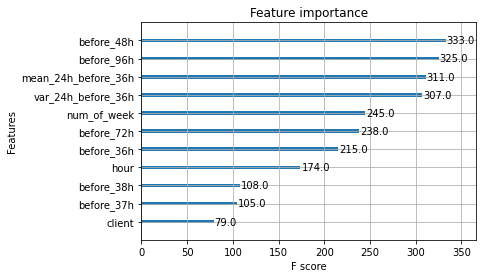

In [46]:
xgb.plot_importance(regressor)

## 6.推論（予測）
https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py

In [47]:
regressor.predict(test_x)

array([1.1317768e+01, 1.1317768e+01, 1.1317768e+01, ..., 1.8498859e+04,
       1.8017615e+04, 1.7940875e+04], dtype=float32)

## 7.推論結果の可視化
client_21について  
正解データ  
Amazon Foreast  
xgboost  

In [48]:
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.client==21]), columns=['xgb'])

In [49]:
df_xgb

,xgb
0,31.295288
1,24.518488
2,34.730373
3,34.730373
4,34.730373
5,41.507172
6,51.620995
7,51.620995
8,47.542473
9,47.542473


In [50]:
df_y = pd.DataFrame(test_y[test_y.client==21]['demand'], columns=['demand']).reset_index(drop=True)

In [51]:
df_y

,demand
0,21.948941
1,28.642590
2,40.317559
3,46.077210
4,40.940224
5,45.143213
6,43.119552
7,38.605230
8,36.425903
9,31.600249


### Foreastの結果

In [52]:
df_forecast = pd.read_csv('../AmazonForecast_predict/my_forecast_export_drop1week_2021-03-03T07-51-36Z_part1.csv')

In [53]:
df_forecast['item_id'].unique()

array(['client_201', 'client_249', 'client_357', 'client_324',
       'client_75', 'client_274', 'client_234', 'client_326',
       'client_313', 'client_260', 'client_133', 'client_318',
       'client_289', 'client_361', 'client_174', 'client_109',
       'client_184', 'client_21', 'client_86', 'client_32', 'client_82',
       'client_177', 'client_10', 'client_226', 'client_103',
       'client_159', 'client_169', 'client_266', 'client_241',
       'client_295', 'client_306', 'client_36', 'client_47', 'client_124',
       'client_158', 'client_230', 'client_285', 'client_35',
       'client_349', 'client_170', 'client_144', 'client_128',
       'client_46', 'client_272', 'client_68', 'client_110', 'client_253',
       'client_252', 'client_191', 'client_23', 'client_267', 'client_9',
       'client_0', 'client_31', 'client_51', 'client_189', 'client_354'],
      dtype=object)

In [54]:
df_result = df_forecast[df_forecast.item_id=='client_21'].reset_index(drop=True)

In [55]:
df_result

,item_id,date,p10,p50,p90
0,client_21,2014-12-30T13:00:00Z,21.333923,25.132877,28.770159
1,client_21,2014-12-30T14:00:00Z,28.073387,32.898338,37.092026
2,client_21,2014-12-30T15:00:00Z,38.639301,43.846355,50.444412
3,client_21,2014-12-30T16:00:00Z,41.978588,46.520233,52.283760
4,client_21,2014-12-30T17:00:00Z,39.904404,46.363640,51.784618
5,client_21,2014-12-30T18:00:00Z,43.310654,50.251816,59.930252
6,client_21,2014-12-30T19:00:00Z,48.920353,55.080643,62.824970
7,client_21,2014-12-30T20:00:00Z,45.416351,52.224514,60.060890
8,client_21,2014-12-30T21:00:00Z,36.452190,43.848927,52.385162
9,client_21,2014-12-30T22:00:00Z,32.266903,38.022995,44.000668


<AxesSubplot:xlabel='date'>

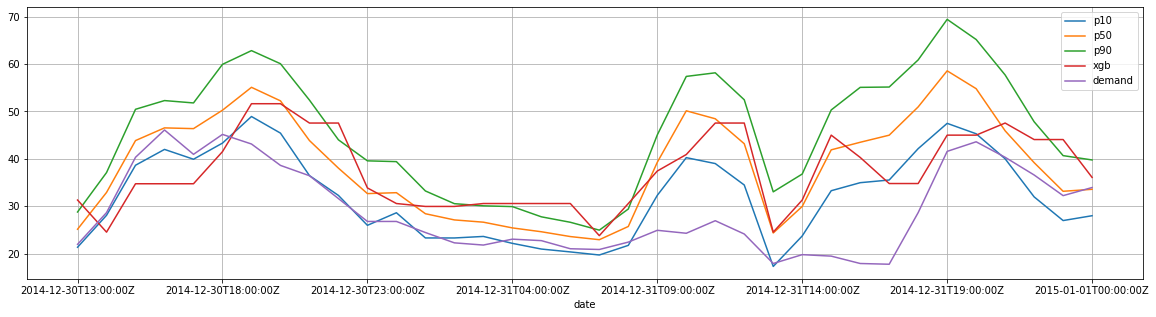

In [56]:
pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

# XGBoostの利点
特徴量の重要度がわかる

【デメリット】
コードのデバッグが大変
特徴量を作り込む必要あり
ハイパーパラメータのチューニング
